<a href="https://colab.research.google.com/github/paolo-peretti/conv/blob/main/conv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import torch
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Preproccessing on dataset

In [32]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


I want see a grid of images of the dataset

bird
.............................................



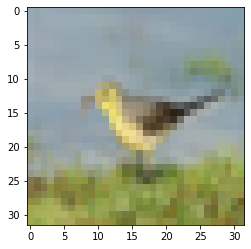

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(training_loader)
images, labels = dataiter.next()
# print(len(images), len(labels))
print(classes[labels[0]])
print('.............................................\n')
imshow(images[0])




Building The Model
============================

One important behavior of ``torch.nn.Module`` is registering parameters.
If a particular ``Module`` subclass has learning weights, these weights
are expressed as instances of ``torch.nn.Parameter``. The ``Parameter``
class is a subclass of ``torch.Tensor``, with the special behavior that
when they are assigned as attributes of a ``Module``, they are added to
the list of that modules parameters. These parameters may be accessed
through the ``parameters()`` method on the ``Module`` class.

As a simple example, here’s a very simple model with two linear layers
and an activation function. We’ll create an instance of it and ask it to
report on its parameters:


In [34]:


class MyModel(torch.nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        
        # CV
        self.conv1 = torch.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(3,3))
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3))

        # FC
        self.linear1 = torch.nn.Linear(16*3*3, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

mymodel = MyModel()

print('The model:')
print(mymodel)



The model:
MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=144, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)
